training_samples 의 값을 300, 500, 1000, 2000 등 값을 바꿔가면서 학습을 해보고 결과를 시각화하세요.

# 원본 IMDB 텍스트 내려받기
- http://mng.bz/0tIo

In [ ]:
!wget --no-check-certificate http://mng.bz/0tIo

--2020-10-30 10:42:31--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2020-10-30 10:42:31--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2020-10-30 10:42:32--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.96.158
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.96.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo’

0tIo                100%[===================>]  57.90M  64.0MB/s    in 0.9s    

2020-10-30 10:42:33 (64.0 MB/s) - ‘0tIo’ saved [60711700/60711700]

In [ ]:
!mkdir '/content/dataset'
!unzip "/content/0tIo" -d "/content/dataset"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/aclImdb/train/pos/7755_9.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._7755_9.txt  
  inflating: /content/dataset/aclImdb/train/pos/7756_10.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._7756_10.txt  
  inflating: /content/dataset/aclImdb/train/pos/7757_9.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._7757_9.txt  
  inflating: /content/dataset/aclImdb/train/pos/7758_7.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._7758_7.txt  
  inflating: /content/dataset/aclImdb/train/pos/7759_10.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._7759_10.txt  
  inflating: /content/dataset/aclImdb/train/pos/775_7.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._775_7.txt  
  inflating: /content/dataset/aclImdb/train/pos/7760_10.txt  
  inflating: /content/dataset/__MACOSX/aclImdb/train/pos/._7760_10.txt  
  inflating: /content/dataset

## 데이터 확인

In [ ]:
import os

In [ ]:
imdb_dir = "/content/dataset/aclImdb"
train_dir = os.path.join(imdb_dir, 'train')

labels=[]
texts=[]
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [ ]:
texts[0]

"I rated this a 3. The dubbing was as bad as I have seen. The plot - yuck. I'm not sure which ruined the movie more. Jet Li is definitely a great martial artist, but I'll stick to Jackie Chan movies until somebody tells me Jet's English is up to par."

In [ ]:
labels[0]

0

# training_samples = 300

## 데이터 토큰화

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
max_len = 100
training_samples = 300
validation_samples = 10000
max_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

88582


In [ ]:
data = pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)

print(data.shape)
print(labels.shape)

(25000, 100)
(25000,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(300, 100)
(300,)
(10000, 100)
(10000,)


## 모델 정의

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

In [ ]:
embedding_dim = 100

model_1 = Sequential()

model_1.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_1.add(Flatten())
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])

## 모델 학습 및 평가

In [ ]:
history1 = model_1.fit(x_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_val, y_val))

Epoch 1/10
10/10 [==============================] - 1s 71ms/step - loss: 0.6930 - acc: 0.5133 - val_loss: 0.6934 - val_acc: 0.5111
Epoch 2/10
10/10 [==============================] - 1s 59ms/step - loss: 0.4877 - acc: 0.9867 - val_loss: 0.6950 - val_acc: 0.5222
Epoch 3/10
10/10 [==============================] - 1s 59ms/step - loss: 0.2319 - acc: 0.9967 - val_loss: 0.7230 - val_acc: 0.5167
Epoch 4/10
10/10 [==============================] - 1s 59ms/step - loss: 0.0930 - acc: 0.9967 - val_loss: 0.7111 - val_acc: 0.5238
Epoch 5/10
10/10 [==============================] - 1s 59ms/step - loss: 0.0385 - acc: 1.0000 - val_loss: 0.7233 - val_acc: 0.5235
Epoch 6/10
10/10 [==============================] - 1s 58ms/step - loss: 0.0176 - acc: 1.0000 - val_loss: 0.7271 - val_acc: 0.5326
Epoch 7/10
10/10 [==============================] - 1s 62ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.7433 - val_acc: 0.5279
Epoch 8/10
10/10 [==============================] - 1s 63ms/step - loss: 0.0043 - a

In [ ]:
model_1.evaluate(x_train, y_train)

10/10 [==============================] - 0s 2ms/step - loss: 7.1607e-04 - acc: 1.0000


[0.0007160676177591085, 1.0]

## 시각화

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

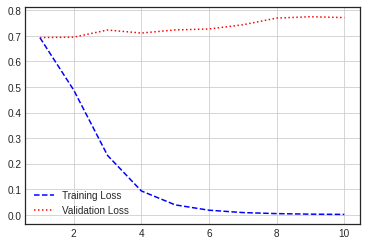

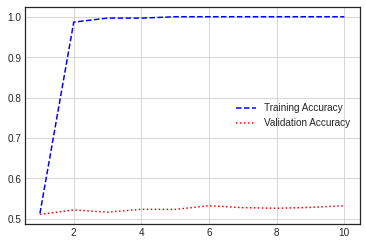

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
acc = history1.history['acc']
val_acc = history1.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

## 테스트 데이터 토큰화

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels=[]
texts=[]
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(25000, 100)
(25000,)


In [ ]:
model_1.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.7743 - acc: 0.5366


[0.7743184566497803, 0.5366399884223938]

# training_samples = 500

## 데이터 토큰화

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
max_len = 100
training_samples = 500
validation_samples = 10000
max_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

87393


In [ ]:
data = pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)

print(data.shape)
print(labels.shape)

(25000, 100)
(25000,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(500, 100)
(500,)
(10000, 100)
(10000,)


## 모델 정의

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

In [ ]:
embedding_dim = 100

model_2 = Sequential()

model_2.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])

## 모델 학습 및 평가

In [ ]:
history2 = model_2.fit(x_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_val, y_val))

Epoch 1/10
16/16 [==============================] - 1s 45ms/step - loss: 0.6930 - acc: 0.5100 - val_loss: 0.6905 - val_acc: 0.5403
Epoch 2/10
16/16 [==============================] - 1s 40ms/step - loss: 0.4902 - acc: 0.9680 - val_loss: 0.6863 - val_acc: 0.5483
Epoch 3/10
16/16 [==============================] - 1s 39ms/step - loss: 0.2084 - acc: 0.9820 - val_loss: 0.6935 - val_acc: 0.5470
Epoch 4/10
16/16 [==============================] - 1s 39ms/step - loss: 0.0664 - acc: 0.9960 - val_loss: 0.7012 - val_acc: 0.5614
Epoch 5/10
16/16 [==============================] - 1s 39ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.7171 - val_acc: 0.5647
Epoch 6/10
16/16 [==============================] - 1s 38ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.7421 - val_acc: 0.5646
Epoch 7/10
16/16 [==============================] - 1s 42ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7488 - val_acc: 0.5694
Epoch 8/10
16/16 [==============================] - 1s 39ms/step - loss: 9.4204e-04

In [ ]:
model_2.evaluate(x_train, y_train)

16/16 [==============================] - 0s 2ms/step - loss: 7.2736e-05 - acc: 1.0000


[7.27357401046902e-05, 1.0]

## 시각화

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

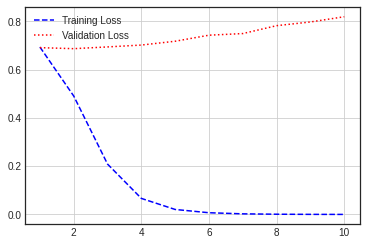

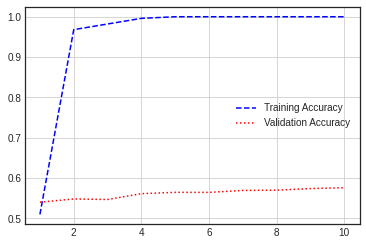

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history['acc']
val_acc = history2.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

## 테스트 데이터 토큰화

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels=[]
texts=[]
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(25000, 100)
(25000,)


In [ ]:
model_2.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.7846 - acc: 0.5917


[0.7846370935440063, 0.5917199850082397]

# training_samples = 1000

## 데이터 토큰화

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
max_len = 100
training_samples = 1000
validation_samples = 10000
max_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

87393


In [ ]:
data = pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)

print(data.shape)
print(labels.shape)

(25000, 100)
(25000,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(1000, 100)
(1000,)
(10000, 100)
(10000,)


## 모델 정의

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

In [ ]:
embedding_dim = 100

model_3 = Sequential()

model_3.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])

## 모델 학습 및 평가

In [ ]:
history3 = model_3.fit(x_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_val, y_val))

Epoch 1/10
32/32 [==============================] - 1s 30ms/step - loss: 0.6923 - acc: 0.5200 - val_loss: 0.6876 - val_acc: 0.5536
Epoch 2/10
32/32 [==============================] - 1s 28ms/step - loss: 0.4474 - acc: 0.9560 - val_loss: 0.6578 - val_acc: 0.6050
Epoch 3/10
32/32 [==============================] - 1s 27ms/step - loss: 0.1310 - acc: 0.9940 - val_loss: 0.6461 - val_acc: 0.6274
Epoch 4/10
32/32 [==============================] - 1s 27ms/step - loss: 0.0257 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.6463
Epoch 5/10
32/32 [==============================] - 1s 27ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.6697 - val_acc: 0.6493
Epoch 6/10
32/32 [==============================] - 1s 27ms/step - loss: 8.6311e-04 - acc: 1.0000 - val_loss: 0.7674 - val_acc: 0.6393
Epoch 7/10
32/32 [==============================] - 1s 28ms/step - loss: 1.9031e-04 - acc: 1.0000 - val_loss: 0.7163 - val_acc: 0.6639
Epoch 8/10
32/32 [==============================] - 1s 30ms/step - loss: 3.

In [ ]:
model_3.evaluate(x_train, y_train)

32/32 [==============================] - 0s 2ms/step - loss: 8.5806e-07 - acc: 1.0000


[8.580630037613446e-07, 1.0]

## 시각화

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

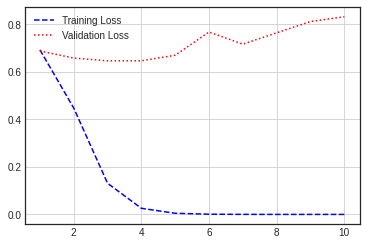

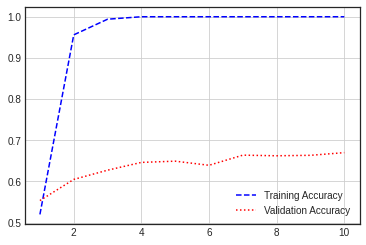

In [ ]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
acc = history3.history['acc']
val_acc = history3.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

## 테스트 데이터 토큰화

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels=[]
texts=[]
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(25000, 100)
(25000,)


In [ ]:
model_3.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.7959 - acc: 0.6812


[0.7959388494491577, 0.6812400221824646]

# training_samples = 2000

## 데이터 토큰화

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
max_len = 100
training_samples = 2000
validation_samples = 10000
max_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

87393


In [ ]:
data = pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)

print(data.shape)
print(labels.shape)

(25000, 100)
(25000,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(2000, 100)
(2000,)
(10000, 100)
(10000,)


## 모델 정의

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

In [ ]:
embedding_dim = 100

model_4 = Sequential()

model_4.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_4.add(Flatten())
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])

## 모델 학습 및 평가

In [ ]:
history4 = model_4.fit(x_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 1s 21ms/step - loss: 0.6871 - acc: 0.5595 - val_loss: 0.6684 - val_acc: 0.6187
Epoch 2/10
63/63 [==============================] - 1s 21ms/step - loss: 0.3508 - acc: 0.9485 - val_loss: 0.5622 - val_acc: 0.7084
Epoch 3/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0518 - acc: 0.9980 - val_loss: 0.5628 - val_acc: 0.7168
Epoch 4/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.5998 - val_acc: 0.7266
Epoch 5/10
63/63 [==============================] - 1s 21ms/step - loss: 3.1235e-04 - acc: 1.0000 - val_loss: 0.6575 - val_acc: 0.7382
Epoch 6/10
63/63 [==============================] - 1s 21ms/step - loss: 2.0558e-05 - acc: 1.0000 - val_loss: 0.7241 - val_acc: 0.7408
Epoch 7/10
63/63 [==============================] - 1s 21ms/step - loss: 1.5797e-06 - acc: 1.0000 - val_loss: 0.7693 - val_acc: 0.7441
Epoch 8/10
63/63 [==============================] - 1s 20ms/step - loss

In [ ]:
model_4.evaluate(x_train, y_train)

63/63 [==============================] - 0s 2ms/step - loss: 2.3458e-08 - acc: 1.0000


[2.3458360587369498e-08, 1.0]

## 시각화

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

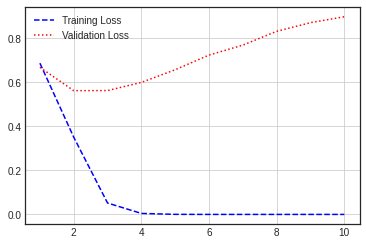

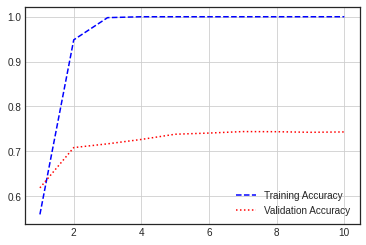

In [ ]:
loss = history4.history['loss']
val_loss = history4.history['val_loss']
acc = history4.history['acc']
val_acc = history4.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

## 테스트 데이터 토큰화

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels=[]
texts=[]
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(25000, 100)
(25000,)


In [ ]:
model_4.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.8265 - acc: 0.7656


[0.8264544010162354, 0.7656000256538391]